# The objective of this case study is to understand what's driving the total spend (Primary Card + Secondary card). Given the factors, predict credit limit for the new applicants.

## IMPORTNIG THE PACKAGES

In [1]:
import numpy as np
import pandas as pd

#import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn.feature_selection import f_regression, RFE, VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

import scipy.stats as stats
# for creating satistical model
import statsmodels.formula.api as smf
# Feature Selection based on importance
from sklearn.feature_selection import f_regression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn import metrics

from scipy import stats
import pylab


## IMPORTING THE FILE

In [3]:
data = pd.read_excel('C:/Users/prabhu/Desktop/PYHON DATA SETS/ML CREDIT CARD SPEND/Data Set.xlsx')
data.head(5)

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0


## EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


In [5]:
print(list(data.columns))

['custid', 'region', 'townsize', 'gender', 'age', 'agecat', 'birthmonth', 'ed', 'edcat', 'jobcat', 'union', 'employ', 'empcat', 'retire', 'income', 'lninc', 'inccat', 'debtinc', 'creddebt', 'lncreddebt', 'othdebt', 'lnothdebt', 'default', 'jobsat', 'marital', 'spoused', 'spousedcat', 'reside', 'pets', 'pets_cats', 'pets_dogs', 'pets_birds', 'pets_reptiles', 'pets_small', 'pets_saltfish', 'pets_freshfish', 'homeown', 'hometype', 'address', 'addresscat', 'cars', 'carown', 'cartype', 'carvalue', 'carcatvalue', 'carbought', 'carbuy', 'commute', 'commutecat', 'commutetime', 'commutecar', 'commutemotorcycle', 'commutecarpool', 'commutebus', 'commuterail', 'commutepublic', 'commutebike', 'commutewalk', 'commutenonmotor', 'telecommute', 'reason', 'polview', 'polparty', 'polcontrib', 'vote', 'card', 'cardtype', 'cardbenefit', 'cardfee', 'cardtenure', 'cardtenurecat', 'card2', 'card2type', 'card2benefit', 'card2fee', 'card2tenure', 'card2tenurecat', 'cardspent', 'card2spent', 'active', 'bfast', 

In [6]:
# check dimension
data.shape

(5000, 130)

In [7]:
# Getting Y varaiable(Dependent variable) > Total Spent = Primary Card + Secondary Card
data['total_spent'] = data['cardspent'] + data['card2spent']

#Droping cardspent and card2spent columns as it is directly related to y - total_spent
data.drop(labels = ['cardspent', 'card2spent'], axis = 1, inplace = True)

In [8]:
#custid is unique
data.drop(labels = ['custid'], axis = 1, inplace = True)

In [9]:
# check dimension
data.shape

(5000, 128)

In [10]:
# checking missing values
data.isna().sum()

region         0
townsize       2
gender         0
age            0
agecat         0
              ..
news           0
response_01    0
response_02    0
response_03    0
total_spent    0
Length: 128, dtype: int64

In [11]:
# total missing values
sum(data.isna().sum())

22003

In [12]:
# type conversion of some variables.
#Identifying Categorical Variables
cat_var = ['region','townsize','gender','agecat','edcat','birthmonth','jobcat','union','empcat','retire',
          'inccat','default','jobsat','marital','spousedcat','homeown','hometype','addresscat','cars','carown',
          'cartype','carcatvalue','carbought','carbuy','commute','commutecat','commutecar',
          'commutemotorcycle','commutecarpool','commutebus','commuterail','commutepublic','commutebike','commutewalk',
         'commutenonmotor','telecommute','reason','polview','polparty','polcontrib','vote','card','cardtype','cardbenefit',
         'cardfee','cardtenurecat','card2','card2type','card2benefit','card2fee','card2tenurecat',
         'active','bfast','churn','tollfree','equip','callcard','wireless','multline','voice','pager','internet','callid',
         'callwait','forward','confer','ebill','owntv','ownvcr','owndvd','owncd','ownpda','ownpc','ownipod','owngame','ownfax',
        'news','response_01','response_02','response_03']

#Typecasting Categorical Variables to object
data[cat_var] = data[cat_var].astype('object')

In [13]:
# Getting Continuous Variables
cont_var = data.select_dtypes(['int64','float64'])
cont_var.columns

Index(['age', 'ed', 'employ', 'income', 'lninc', 'debtinc', 'creddebt',
       'lncreddebt', 'othdebt', 'lnothdebt', 'spoused', 'reside', 'pets',
       'pets_cats', 'pets_dogs', 'pets_birds', 'pets_reptiles', 'pets_small',
       'pets_saltfish', 'pets_freshfish', 'address', 'carvalue', 'commutetime',
       'cardtenure', 'card2tenure', 'tenure', 'longmon', 'lnlongmon',
       'longten', 'lnlongten', 'tollmon', 'lntollmon', 'tollten', 'lntollten',
       'equipmon', 'lnequipmon', 'equipten', 'lnequipten', 'cardmon',
       'lncardmon', 'cardten', 'lncardten', 'wiremon', 'lnwiremon', 'wireten',
       'lnwireten', 'hourstv', 'total_spent'],
      dtype='object')

In [14]:
#Removing categorical variables having numerical variables
data.drop(labels = ['agecat', 'edcat', 'empcat', 'inccat', 'spousedcat', 'addresscat', 'carcatvalue', 'cardtenurecat', 'card2tenurecat'], axis = 1, inplace = True)

In [15]:
data.shape

(5000, 119)

In [16]:
# Getting Categorical Variables
cat_var = data.select_dtypes(['object'])
cat_var.columns

Index(['region', 'townsize', 'gender', 'birthmonth', 'jobcat', 'union',
       'retire', 'default', 'jobsat', 'marital', 'homeown', 'hometype', 'cars',
       'carown', 'cartype', 'carbought', 'carbuy', 'commute', 'commutecat',
       'commutecar', 'commutemotorcycle', 'commutecarpool', 'commutebus',
       'commuterail', 'commutepublic', 'commutebike', 'commutewalk',
       'commutenonmotor', 'telecommute', 'reason', 'polview', 'polparty',
       'polcontrib', 'vote', 'card', 'cardtype', 'cardbenefit', 'cardfee',
       'card2', 'card2type', 'card2benefit', 'card2fee', 'active', 'bfast',
       'churn', 'tollfree', 'equip', 'callcard', 'wireless', 'multline',
       'voice', 'pager', 'internet', 'callid', 'callwait', 'forward', 'confer',
       'ebill', 'owntv', 'ownvcr', 'owndvd', 'owncd', 'ownpda', 'ownpc',
       'ownipod', 'owngame', 'ownfax', 'news', 'response_01', 'response_02',
       'response_03'],
      dtype='object')

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 119 entries, region to total_spent
dtypes: float64(29), int64(19), object(71)
memory usage: 4.5+ MB


## CREATING UDF'S

In [18]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [19]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [20]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode().iloc[0])
    return x

In [21]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

#### getting the summary for both categorical and continous variable

In [22]:
# summary for contineous variable
cont_summary = cont_var.apply(continuous_var_summary).round(1)
cont_summary

,age,ed,employ,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,...,cardmon,lncardmon,cardten,lncardten,wiremon,lnwiremon,wireten,lnwireten,hourstv,total_spent
N,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,4999.0,5000.0,4999.0,...,5000.0,3581.0,4998.0,3578.0,5000.0,1344.0,5000.0,1344.0,5000.0,5000.0
NMISS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1419.0,2.0,1422.0,0.0,3656.0,0.0,3656.0,0.0,0.0
SUM,235128.0,72715.0,48652.0,273798.0,18499.5,49770.8,9286.6,-652.1,18272.3,3483.9,...,77219.2,10419.8,3600951.0,22993.3,53506.0,4845.1,2109923.1,9150.1,98225.0,2490393.2
MEAN,47.0,14.5,9.7,54.8,3.7,10.0,1.9,-0.1,3.7,0.7,...,15.4,2.9,720.5,6.4,10.7,3.6,422.0,6.8,19.6,498.1
MEDIAN,47.0,14.0,7.0,38.0,3.6,8.8,0.9,-0.1,2.1,0.7,...,13.8,2.9,425.0,6.6,0.0,3.6,0.0,7.1,20.0,414.2
STD,17.8,3.3,9.7,55.4,0.7,6.4,3.4,1.3,5.4,1.1,...,15.0,0.6,922.2,1.2,19.8,0.4,1001.0,1.3,5.2,351.5
VAR,315.8,10.8,93.9,3066.7,0.6,41.0,11.7,1.6,29.1,1.3,...,225.2,0.3,850499.9,1.4,392.0,0.2,1002007.6,1.6,26.7,123572.8
MIN,18.0,6.0,0.0,9.0,2.2,0.0,0.0,-6.6,0.0,-4.1,...,0.0,1.2,0.0,1.6,0.0,2.5,0.0,2.5,0.0,8.1
P1,18.0,8.0,0.0,9.0,2.2,0.7,0.0,-3.4,0.1,-2.2,...,0.0,1.7,0.0,2.5,0.0,2.8,0.0,3.0,0.0,58.2
P5,20.0,9.0,0.0,13.0,2.6,1.9,0.1,-2.3,0.3,-1.2,...,0.0,2.0,0.0,4.1,0.0,3.0,0.0,4.1,12.0,133.1


In [23]:
# summary for categorical variable
cat_summary = cat_var.apply(categorical_var_summary).round(1)
cat_summary

,region,townsize,gender,birthmonth,jobcat,union,retire,default,jobsat,marital,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
N,5000.0,4998.0,5000.0,5000,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
NMISS,0.0,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MODE,5.0,1.0,1.0,September,2.0,0.0,0.0,0.0,3.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FREQ,1027.0,1436.0,2518.0,458,1640.0,4244.0,4262.0,3829.0,1085.0,2599.0,...,4664.0,3995.0,3164.0,2604.0,2626.0,4106.0,2637.0,4582.0,4351.0,4487.0
PERCENT,20.5,28.7,50.4,9.16,32.8,84.9,85.2,76.6,21.7,52.0,...,93.3,79.9,63.3,52.1,52.5,82.1,52.7,91.6,87.0,89.7


## DATA PERPARERATION

In [24]:
# outlier treatment
cont_var_outlier = cont_var.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), 
                                                         upper = x.quantile(0.99)))


In [25]:
cont_var.apply(continuous_var_summary).round(1)


,age,ed,employ,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,...,cardmon,lncardmon,cardten,lncardten,wiremon,lnwiremon,wireten,lnwireten,hourstv,total_spent
N,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,4999.0,5000.0,4999.0,...,5000.0,3581.0,4998.0,3578.0,5000.0,1344.0,5000.0,1344.0,5000.0,5000.0
NMISS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1419.0,2.0,1422.0,0.0,3656.0,0.0,3656.0,0.0,0.0
SUM,235128.0,72715.0,48652.0,273798.0,18499.5,49770.8,9286.6,-652.1,18272.3,3483.9,...,77219.2,10419.8,3600951.0,22993.3,53506.0,4845.1,2109923.1,9150.1,98225.0,2490393.2
MEAN,47.0,14.5,9.7,54.8,3.7,10.0,1.9,-0.1,3.7,0.7,...,15.4,2.9,720.5,6.4,10.7,3.6,422.0,6.8,19.6,498.1
MEDIAN,47.0,14.0,7.0,38.0,3.6,8.8,0.9,-0.1,2.1,0.7,...,13.8,2.9,425.0,6.6,0.0,3.6,0.0,7.1,20.0,414.2
STD,17.8,3.3,9.7,55.4,0.7,6.4,3.4,1.3,5.4,1.1,...,15.0,0.6,922.2,1.2,19.8,0.4,1001.0,1.3,5.2,351.5
VAR,315.8,10.8,93.9,3066.7,0.6,41.0,11.7,1.6,29.1,1.3,...,225.2,0.3,850499.9,1.4,392.0,0.2,1002007.6,1.6,26.7,123572.8
MIN,18.0,6.0,0.0,9.0,2.2,0.0,0.0,-6.6,0.0,-4.1,...,0.0,1.2,0.0,1.6,0.0,2.5,0.0,2.5,0.0,8.1
P1,18.0,8.0,0.0,9.0,2.2,0.7,0.0,-3.4,0.1,-2.2,...,0.0,1.7,0.0,2.5,0.0,2.8,0.0,3.0,0.0,58.2
P5,20.0,9.0,0.0,13.0,2.6,1.9,0.1,-2.3,0.3,-1.2,...,0.0,2.0,0.0,4.1,0.0,3.0,0.0,4.1,12.0,133.1


In [26]:
#Columns having more than 1000 missing values
miss_value = data.isna().sum()
miss_value[miss_value>1000]

lntollmon     2622
lntollten     2622
lnequipmon    3296
lnequipten    3296
lncardmon     1419
lncardten     1422
lnwiremon     3656
lnwireten     3656
dtype: int64

In [27]:
# total missing values
tot_miss = sum(data.isna().sum())
tot_miss

22003

In [28]:
# % age of missing values
data.isna().sum()/data.shape[0]*100

region         0.00
townsize       0.04
gender         0.00
age            0.00
birthmonth     0.00
               ... 
news           0.00
response_01    0.00
response_02    0.00
response_03    0.00
total_spent    0.00
Length: 119, dtype: float64

In [29]:
# Dropping variables having more than 1000 missing values
data.drop(['lntollmon', 'lntollten', 'lnequipmon', 'lnequipten', 'lncardmon',
       'lncardten', 'lnwiremon', 'lnwireten'], axis = 1, inplace = True)

In [30]:
data.shape

(5000, 111)

In [31]:
# missing value imputation
cont_var = cont_var.apply(missing_imputation)
cat_var = cat_var.apply(missing_imputation)


In [32]:
cont_var.isna().sum()/cont_var.shape[0]*100

age               0.0
ed                0.0
employ            0.0
income            0.0
lninc             0.0
debtinc           0.0
creddebt          0.0
lncreddebt        0.0
othdebt           0.0
lnothdebt         0.0
spoused           0.0
reside            0.0
pets              0.0
pets_cats         0.0
pets_dogs         0.0
pets_birds        0.0
pets_reptiles     0.0
pets_small        0.0
pets_saltfish     0.0
pets_freshfish    0.0
address           0.0
carvalue          0.0
commutetime       0.0
cardtenure        0.0
card2tenure       0.0
tenure            0.0
longmon           0.0
lnlongmon         0.0
longten           0.0
lnlongten         0.0
tollmon           0.0
lntollmon         0.0
tollten           0.0
lntollten         0.0
equipmon          0.0
lnequipmon        0.0
equipten          0.0
lnequipten        0.0
cardmon           0.0
lncardmon         0.0
cardten           0.0
lncardten         0.0
wiremon           0.0
lnwiremon         0.0
wireten           0.0
lnwireten 

In [33]:
cont_var.apply(continuous_var_summary).round(1)

,age,ed,employ,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,...,cardmon,lncardmon,cardten,lncardten,wiremon,lnwiremon,wireten,lnwireten,hourstv,total_spent
N,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
NMISS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SUM,235128.0,72715.0,48652.0,273798.0,18499.5,49770.8,9286.6,-652.3,18272.3,3484.6,...,77219.2,14548.7,3602392.0,32131.5,53506.0,18025.0,2109923.1,34040.7,98225.0,2490393.2
MEAN,47.0,14.5,9.7,54.8,3.7,10.0,1.9,-0.1,3.7,0.7,...,15.4,2.9,720.5,6.4,10.7,3.6,422.0,6.8,19.6,498.1
MEDIAN,47.0,14.0,7.0,38.0,3.6,8.8,0.9,-0.1,2.1,0.7,...,13.8,2.9,425.0,6.4,0.0,3.6,0.0,6.8,20.0,414.2
STD,17.8,3.3,9.7,55.4,0.7,6.4,3.4,1.3,5.4,1.1,...,15.0,0.5,922.0,1.0,19.8,0.2,1001.0,0.7,5.2,351.5
VAR,315.8,10.8,93.9,3066.7,0.6,41.0,11.7,1.6,29.1,1.3,...,225.2,0.2,850159.7,1.0,392.0,0.0,1002007.6,0.4,26.7,123572.8
MIN,18.0,6.0,0.0,9.0,2.2,0.0,0.0,-6.6,0.0,-4.1,...,0.0,1.2,0.0,1.6,0.0,2.5,0.0,2.5,0.0,8.1
P1,18.0,8.0,0.0,9.0,2.2,0.7,0.0,-3.4,0.1,-2.2,...,0.0,1.7,0.0,2.7,0.0,2.9,0.0,3.8,0.0,58.2
P5,20.0,9.0,0.0,13.0,2.6,1.9,0.1,-2.3,0.3,-1.2,...,0.0,2.1,0.0,4.5,0.0,3.2,0.0,5.7,12.0,133.1


In [34]:
# creating dummies
for c_feature in cat_var:
    cat_var[c_feature]=cat_var[c_feature].astype('category')
    cat_var=create_dummies(cat_var,c_feature)

In [35]:
cat_var.head()

,region_2,region_3,region_4,region_5,townsize_2.0,townsize_3.0,townsize_4.0,townsize_5.0,gender_1,birthmonth_August,...,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1
0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,1,0,0,0,1,0
1,0,0,0,1,0,0,0,1,0,0,...,1,1,1,1,1,1,1,0,0,0
2,0,1,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,1,0,0,0,0,...,1,0,1,1,1,0,1,1,0,0
4,1,0,0,0,1,0,0,0,0,0,...,1,0,1,0,1,0,0,0,1,0


In [36]:
print(list(cat_var.columns))

['region_2', 'region_3', 'region_4', 'region_5', 'townsize_2.0', 'townsize_3.0', 'townsize_4.0', 'townsize_5.0', 'gender_1', 'birthmonth_August', 'birthmonth_December', 'birthmonth_February', 'birthmonth_January', 'birthmonth_July', 'birthmonth_June', 'birthmonth_March', 'birthmonth_May', 'birthmonth_November', 'birthmonth_October', 'birthmonth_September', 'jobcat_2', 'jobcat_3', 'jobcat_4', 'jobcat_5', 'jobcat_6', 'union_1', 'retire_1', 'default_1', 'jobsat_2', 'jobsat_3', 'jobsat_4', 'jobsat_5', 'marital_1', 'homeown_1', 'hometype_2', 'hometype_3', 'hometype_4', 'cars_1', 'cars_2', 'cars_3', 'cars_4', 'cars_5', 'cars_6', 'cars_7', 'cars_8', 'carown_0', 'carown_1', 'cartype_0', 'cartype_1', 'carbought_0', 'carbought_1', 'carbuy_1', 'commute_2', 'commute_3', 'commute_4', 'commute_5', 'commute_6', 'commute_7', 'commute_8', 'commute_9', 'commute_10', 'commutecat_2', 'commutecat_3', 'commutecat_4', 'commutecat_5', 'commutecar_1', 'commutemotorcycle_1', 'commutecarpool_1', 'commutebus_1', 

In [37]:
data.shape

(5000, 111)

#### AFTER ALL THE TREATMENTS , COMBINING BOTH NUMERIC & OBJECT DATASET TOGHER FOR FINAL ANALYSIS

In [38]:
data_new = pd.concat([cont_var, cat_var], axis = 1)

In [39]:
data_new.head(2)

,age,ed,employ,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,...,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1
0,20,15,0,31,3.433987,11.1,1.200909,0.183079,2.240091,0.806516,...,0,0,0,1,1,0,0,0,1,0
1,22,17,0,15,2.708050,18.6,1.222020,0.200505,1.567980,0.449788,...,1,1,1,1,1,1,1,0,0,0


In [40]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 191 entries, age to response_03_1
dtypes: float64(29), int64(19), uint8(143)
memory usage: 2.5 MB


In [41]:
# checking for missing
sum(data_new.isna().sum())

0

## Assumption check

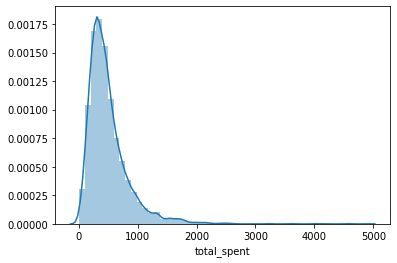

In [42]:
# Distribution of variables
sns.distplot(data_new.total_spent)
plt.show()
# this distribution is highly skewed

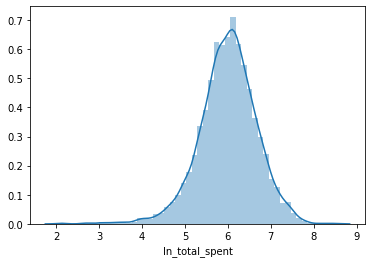

In [43]:
# applying log transformation: log is rescalling the data and making the distribution normal
data_new['ln_total_spent'] = np.log(data_new['total_spent'])
# Distribution of variables
sns.distplot(data_new.ln_total_spent)
plt.show()

In [44]:
data_new.total_spent.skew()

2.707546987697521

In [45]:
data_new.ln_total_spent.skew()

-0.539836787814146

In [46]:
data_new.shape

(5000, 192)

In [48]:
# Linearity: correlation matrix (ranges from 1 to -1)
corrm = data_new.corr()


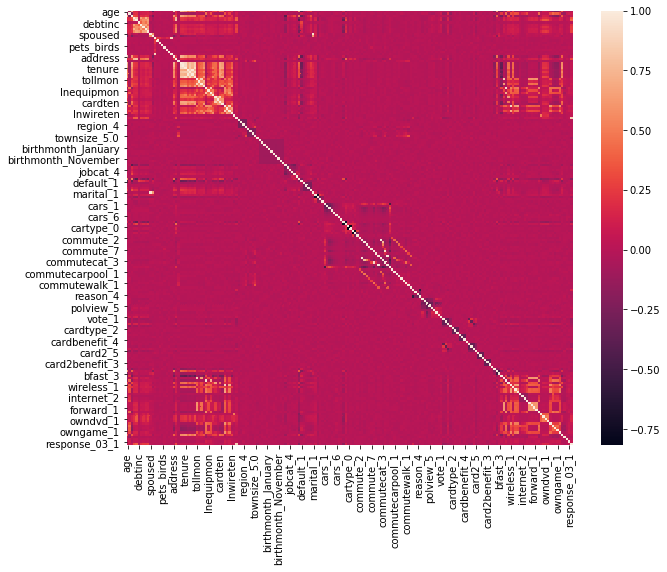

In [49]:
plt.figure(figsize = (10, 8))
sns.heatmap(data_new.corr())

### Variable reducton

In [50]:
#Selecting features
feature_columns = data_new.columns.difference(['ln_total_spent', 'total_spent'])
features_x = data_new[feature_columns]
target_y = data_new.ln_total_spent

In [51]:
#RFE

In [52]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

#import itertools

#Checking RFE 

lm = LinearRegression()
#create the RFE model and select 30 attributes
rfe = RFE(lm, n_features_to_select=30)
rfe = rfe.fit(features_x, target_y)


### F-Regressiom

In [53]:

# perform the ftest for each of X varibales with y
F_values, p_values  = f_regression( features_x, target_y )

# store the data as a dataframe
F_Regression_output = pd.DataFrame([feature_columns, F_values, p_values.round(4)]).T

# rename the columns
F_Regression_output.columns = ['Features', 'F_values', 'p_values']

# Get the significant variables are 90% : p = 0.1
feature_columns = list(F_Regression_output.loc[ F_Regression_output.p_values <= 0.1, 'Features' ])

# display all significant variables after f_regression
print(feature_columns)

['address', 'bfast_2', 'bfast_3', 'callid_1', 'callwait_1', 'card2_2', 'card2_3', 'card2_4', 'card2_5', 'card2benefit_3', 'card2tenure', 'card_2', 'card_3', 'card_4', 'card_5', 'cardtenure', 'carown_0', 'carown_1', 'cars_1', 'cartype_0', 'carvalue', 'commute_4', 'commutebike_1', 'confer_1', 'creddebt', 'ebill_1', 'ed', 'employ', 'equip_1', 'equipmon', 'equipten', 'forward_1', 'gender_1', 'homeown_1', 'hometype_2', 'hometype_3', 'hourstv', 'income', 'internet_3', 'internet_4', 'jobcat_2', 'jobcat_3', 'jobsat_4', 'jobsat_5', 'lncardten', 'lncreddebt', 'lnequipmon', 'lnequipten', 'lninc', 'lnlongmon', 'lnlongten', 'lnothdebt', 'lntollmon', 'lntollten', 'lnwiremon', 'lnwireten', 'longmon', 'longten', 'multline_1', 'news_1', 'othdebt', 'owncd_1', 'owndvd_1', 'ownfax_1', 'owngame_1', 'ownipod_1', 'ownpc_1', 'ownpda_1', 'owntv_1', 'ownvcr_1', 'pager_1', 'pets_reptiles', 'polcontrib_1', 'polview_6', 'reason_2', 'reason_3', 'reason_4', 'region_5', 'response_02_1', 'response_03_1', 'retire_1', '

### VIF (Variance Inflation Factor): Check the multicollinieirity for all the variables in the model

In [54]:
model_param = 'ln_total_spent ~ ' + ' + '.join(feature_columns)
model_param

'ln_total_spent ~ address + bfast_2 + bfast_3 + callid_1 + callwait_1 + card2_2 + card2_3 + card2_4 + card2_5 + card2benefit_3 + card2tenure + card_2 + card_3 + card_4 + card_5 + cardtenure + carown_0 + carown_1 + cars_1 + cartype_0 + carvalue + commute_4 + commutebike_1 + confer_1 + creddebt + ebill_1 + ed + employ + equip_1 + equipmon + equipten + forward_1 + gender_1 + homeown_1 + hometype_2 + hometype_3 + hourstv + income + internet_3 + internet_4 + jobcat_2 + jobcat_3 + jobsat_4 + jobsat_5 + lncardten + lncreddebt + lnequipmon + lnequipten + lninc + lnlongmon + lnlongten + lnothdebt + lntollmon + lntollten + lnwiremon + lnwireten + longmon + longten + multline_1 + news_1 + othdebt + owncd_1 + owndvd_1 + ownfax_1 + owngame_1 + ownipod_1 + ownpc_1 + ownpda_1 + owntv_1 + ownvcr_1 + pager_1 + pets_reptiles + polcontrib_1 + polview_6 + reason_2 + reason_3 + reason_4 + region_5 + response_02_1 + response_03_1 + retire_1 + spoused + tenure + tollfree_1 + tollmon + tollten + voice_1 + vot

In [55]:
# High VIF of the variable means information in that variable has already been explained by 
# other X variables present in the model

# import the packages for vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# separate the Y and X variables
y, X = dmatrices(model_param, data_new, return_type = 'dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF_Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# display the output
vif.round(1)

,Features,VIF_Factor
0,Intercept,19674.6
1,address,2.9
2,bfast_2,1.9
3,bfast_3,1.5
4,callid_1,2.2
...,...,...
87,voice_1,2.2
88,vote_1,1.1
89,wireless_1,84.5
90,wiremon,150.6


In [56]:
vif1=vif[vif['VIF_Factor']<4].reset_index().loc[:,['Features']]
vif1.drop([0],axis=0,inplace=True)
f_cols= vif1["Features"]
f_cols

1           bfast_2
2           bfast_3
3          callid_1
4        callwait_1
5           card2_2
          ...      
58    response_03_1
59         retire_1
60          spoused
61          voice_1
62           vote_1
Name: Features, Length: 62, dtype: object

In [57]:
print(list(f_cols))

['bfast_2', 'bfast_3', 'callid_1', 'callwait_1', 'card2_2', 'card2_3', 'card2_4', 'card2_5', 'card2benefit_3', 'card_2', 'card_3', 'card_4', 'card_5', 'carown_0', 'cars_1', 'cartype_0', 'commute_4', 'commutebike_1', 'confer_1', 'creddebt', 'ebill_1', 'ed', 'forward_1', 'gender_1', 'homeown_1', 'hometype_2', 'hometype_3', 'hourstv', 'internet_3', 'internet_4', 'jobcat_2', 'jobcat_3', 'jobsat_4', 'jobsat_5', 'lncardten', 'lncreddebt', 'lnothdebt', 'multline_1', 'news_1', 'owncd_1', 'owndvd_1', 'ownfax_1', 'owngame_1', 'ownipod_1', 'ownpc_1', 'ownpda_1', 'owntv_1', 'ownvcr_1', 'pager_1', 'pets_reptiles', 'polcontrib_1', 'polview_6', 'reason_2', 'reason_3', 'reason_4', 'region_5', 'response_02_1', 'response_03_1', 'retire_1', 'spoused', 'voice_1', 'vote_1']


# Train & Test

In [58]:
#For Statistical modelling
train, test = train_test_split(data_new, test_size = 0.3, random_state = 123)

# Modeling

In [59]:
model_param1 = 'ln_total_spent ~ ' + ' + '.join(f_cols)

In [60]:
#Building model
model1 = smf.ols(formula = model_param1, data = train).fit()

In [61]:
print(model1.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.297    
Dependent Variable: ln_total_spent   AIC:                6101.2509
Date:               2021-06-16 09:46 BIC:                6489.3636
No. Observations:   3500             Log-Likelihood:     -2987.6  
Df Model:           62               F-statistic:        24.90    
Df Residuals:       3437             Prob (F-statistic): 4.61e-228
R-squared:          0.310            Scale:              0.32874  
------------------------------------------------------------------
                   Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept          6.6142   0.1305  50.7004 0.0000  6.3584  6.8700
bfast_2            0.0179   0.0275   0.6522 0.5143 -0.0360  0.0719
bfast_3            0.0213   0.0240   0.8907 0.3732 -0.0256  0.0683
callid_1          -0.0142   0.0284  -0.5009 0.6165 -0.0700  0.0415
callwait_1   

# Final Model

In [62]:
#Final model formula
model_param2 = '''ln_total_spent ~ card2benefit_3 + card2_5 + reason_2 + internet_4 + lninc + card_2 + card_5 + region_5
+ card2_2 + card_4 + card2_4 + card2benefit_3 + card2_3 + card_3 + gender_1 + internet_3 '''

In [63]:
#building model with final model formula
model2 = smf.ols(formula = model_param2, data = train).fit()

In [64]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_total_spent   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     118.5
Date:                Wed, 16 Jun 2021   Prob (F-statistic):          5.86e-298
Time:                        09:46:14   Log-Likelihood:                -2915.1
No. Observations:                3500   AIC:                             5862.
Df Residuals:                    3484   BIC:                             5961.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.5057      0.063     87.

## Prediction

In [65]:
#Predicting total spent on train and test dataset
train.loc[:,'lr_pred_spent'] = np.exp(model2.predict(train))
test.loc[:,'lr_pred_spent'] = np.exp(model2.predict(test))

#Getting Mean Absolute Percentage Error - MAPE
MAPE_train = np.mean(np.abs(train['total_spent'] - train['lr_pred_spent'])/train['total_spent'])
MAPE_test = np.mean(np.abs(test['total_spent'] - test['lr_pred_spent'])/test['total_spent'])

print('Training MAPE: ',MAPE_train,' | ','Testing MAPE:' ,MAPE_test)

Training MAPE:  0.5283244104112956  |  Testing MAPE: 0.4825508810095084


C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [66]:
#Getting Mean Squared Error Metric - MSE
MSE_train = metrics.mean_squared_error(train.total_spent, train.lr_pred_spent)
MSE_test = metrics.mean_squared_error(test.total_spent, test.lr_pred_spent)

print('Training MSE: ',MSE_train,' | ','Testing MSE:' ,MSE_test)


Training MSE:  88238.34746849354  |  Testing MSE: 83062.06677600392


In [67]:
#Getting Root Mean Squared Error - RMSE
RMSE_train = np.sqrt(MSE_train)
RMSE_test = np.sqrt(MSE_test)
print('Training RMSE: ',RMSE_train,' | ','Testing RMSE:' ,RMSE_test)

Training RMSE:  297.0494024038654  |  Testing RMSE: 288.20490414981475


In [68]:
#Getting Mean Absolute Error Metric - MAE
MAE_train = metrics.mean_absolute_error(train.total_spent, train.lr_pred_spent)
MAE_test = metrics.mean_absolute_error(test.total_spent, test.lr_pred_spent)

print('Training MAE: ',MAE_train,' | ','Testing MAE:' ,MAE_test)

Training MAE:  193.70951836844375  |  Testing MAE: 191.62672594666375


In [69]:
#Getting Root Mean Squared Percentage Error - RMSPE
RMSPE_train = np.sqrt(np.mean(((train['total_spent'] - train['lr_pred_spent'])/train['total_spent'])**2))
RMSPE_test = np.sqrt(np.mean(((test['total_spent'] - test['lr_pred_spent'])/test['total_spent'])**2))

print('Training RMSPE:', RMSPE_train,' | ','Testing RMSPE:', RMSPE_test)

Training RMSPE: 1.256724647391825  |  Testing RMSPE: 1.1605402983045152


In [70]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train.total_spent, train.lr_pred_spent)
Corr_test = stats.stats.pearsonr(test.total_spent, test.lr_pred_spent)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.5815105351067776, 7.3879717e-316) | Test Data:  (0.5563587769867827, 1.2166942623817954e-122)


## Decile Analysis

In [71]:

#Creating Deciles
train.loc[:,'Deciles'] = pd.qcut(train.lr_pred_spent, 10, labels = False)
test.loc[:,'Deciles'] = pd.qcut(test.lr_pred_spent, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
decile_train = train.groupby(['Deciles'])[['total_spent','lr_pred_spent']].mean().reset_index().sort_values(by = 'Deciles', ascending = False)
decile_test = test.groupby(['Deciles'])[['total_spent','lr_pred_spent']].mean().reset_index().sort_values(by = 'Deciles', ascending = False)

C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [72]:
decile_train

,Deciles,total_spent,lr_pred_spent
9,9,961.381114,871.461184
8,8,708.957686,619.766924
7,7,582.161143,519.154012
6,6,521.867600,454.713377
5,5,462.687200,403.431408
4,4,414.689086,362.230259
3,3,382.150200,326.400555
2,2,350.292000,295.210770
1,1,312.295543,265.122330
0,0,259.076057,220.407169


In [73]:
decile_test

,Deciles,total_spent,lr_pred_spent
9,9,892.308667,869.983469
8,8,736.497067,632.206257
7,7,586.554533,532.280466
6,6,537.862333,467.701683
5,5,476.590867,416.126199
4,4,463.243400,370.207625
3,3,384.985267,331.519302
2,2,369.023133,301.647223
1,1,319.799000,271.337081
0,0,272.788933,223.247359


### Residual Analysis

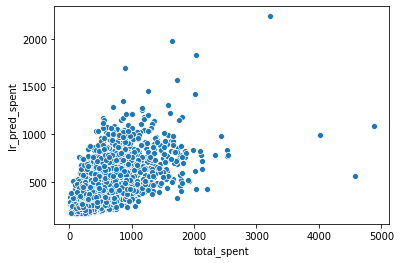

In [74]:
#True vs Predicted plot
sns.scatterplot(x = train.total_spent, y = train.lr_pred_spent)
plt.show()

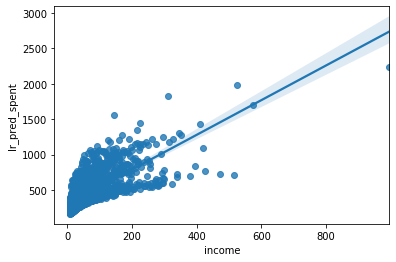

In [75]:
#Assumption: Regression model is linear
sns.regplot(x = train.income, y = train.lr_pred_spent)
plt.show()

In [76]:
#Assumption: Mean of Residuals is zero
model2.resid.mean()

6.889726884245257e-16

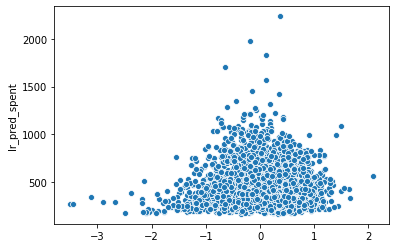

In [77]:
#Assumption: Homoscedasticity of residuals
sns.scatterplot(x = model2.resid, y = train.lr_pred_spent)
plt.show()

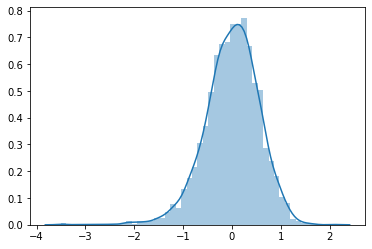

In [78]:
#Assumption: Normality of Residuals
sns.distplot(model2.resid)
plt.show()

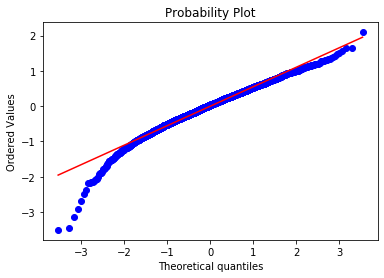

In [79]:
#Q-Q plot of Residuals
stats.probplot(model2.resid, dist='norm', plot=pylab)
pylab.show()

In [80]:
#assumption: residuals/errors of the model should not be correlated with dependant (Y) variable
print(stats.stats.pearsonr(model2.resid, train.lr_pred_spent))

(-0.007892946858002379, 0.6406476214178125)


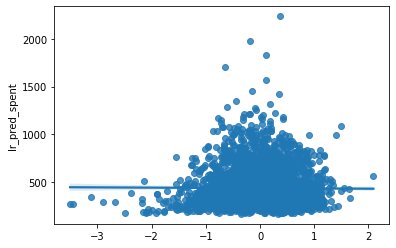

In [81]:
sns.regplot(x=model2.resid, y=train.lr_pred_spent)

In [82]:
#Getting final features
X_cols = model2.pvalues.index.difference(['Intercept'])
X = data_new[X_cols]
Y = data_new.ln_total_spent

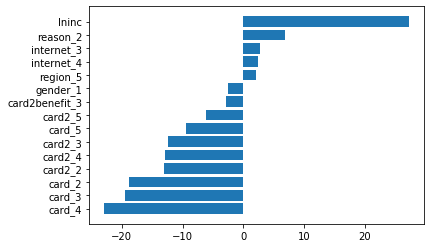

In [84]:
#Getting importance of factors
lr_fi = pd.DataFrame({'Features' : model2.tvalues[1:].index,
                      'T_value' : model2.tvalues[1:]
                     }).sort_values(by = 'T_value').reset_index(drop = True)

plt.barh(width = lr_fi.T_value, y = lr_fi.Features)
plt.show()

#### Getting Train and Test dataset for Machine Learning modelling

In [85]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.3, random_state = 123)

### KNN Model

In [86]:
#Getting parameters for best fit using GridSeachCV
pg = {'n_neighbors' : range(10,25,1)
              }

gscv_knn = GridSearchCV(estimator = KNeighborsRegressor(), 
                     param_grid = pg,
                     scoring = 'neg_mean_absolute_error',
                     cv = 14,
                     n_jobs = -1).fit(train_x, train_y)

In [87]:
#Best fit Parameters
gscv_knn.best_params_

{'n_neighbors': 23}

In [88]:
#Best Score
-1 * gscv_knn.best_score_

0.45246007803928373

In [89]:
#Using best fit parameters to fit the model
knn = gscv_knn.best_estimator_

#Predicting total spent on train and test dataset
train.loc[:, 'knn_pred_spent'] = np.exp(knn.predict(train_x))
test.loc[:, 'knn_pred_spent'] = np.exp(knn.predict(test_x))

#R-square Score
knn_r2 = metrics.r2_score(train.total_spent, train.knn_pred_spent)

print('R-square Score:', knn_r2)

#Getting Mean Absolute Percentage Error - MAPE
knn_MAPE_train = np.mean(np.abs(train['total_spent'] - train['knn_pred_spent'])/train['total_spent'])
knn_MAPE_test = np.mean(np.abs(test['total_spent'] - test['knn_pred_spent'])/test['total_spent'])
                    
print('Training MAPE:',knn_MAPE_train,' | ','Testing MAPE:',knn_MAPE_test)

C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


R-square Score: 0.23216920945400332
Training MAPE: 0.5198265511704533  |  Testing MAPE: 0.49393987990781474


C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [90]:
#Getting Mean Squared Error Metric - MSE
MSE_train = metrics.mean_squared_error(train.total_spent, train.knn_pred_spent)
MSE_test = metrics.mean_squared_error(test.total_spent, test.knn_pred_spent)

#Getting Root Mean Squared Error - RMSE
knn_RMSE_train = np.sqrt(MSE_train)
knn_RMSE_test = np.sqrt(MSE_test)

print('Training MSE: ',MSE_train,' | ','Testing MSE:' ,MSE_test)
print('Training RMSE: ',knn_RMSE_train,' | ','Testing RMSE:' ,knn_RMSE_test)

Training MSE:  97779.8776674606  |  Testing MSE: 94856.58448750258
Training RMSE:  312.6977417050859  |  Testing RMSE: 307.9879615950964


In [91]:
#Getting Mean Absolute Error Metric - MAE
MAE_train = metrics.mean_absolute_error(train.total_spent, train.knn_pred_spent)
MAE_test = metrics.mean_absolute_error(test.total_spent, test.knn_pred_spent)

print('Training MAE: ',MAE_train,' | ','Testing MAE:' ,MAE_test)

Training MAE:  196.98475810116642  |  Testing MAE: 198.8471594052109


In [92]:
#Getting Root Mean Squared Percentage Error - RMSPE
knn_RMSPE_train = np.sqrt(np.mean(((train['total_spent'] - train['knn_pred_spent'])/train['total_spent'])**2))
knn_RMSPE_test = np.sqrt(np.mean(((test['total_spent'] - test['knn_pred_spent'])/test['total_spent'])**2))

print('Training RMSPE:', knn_RMSPE_train,' | ','Testing RMSPE:', knn_RMSPE_test)

Training RMSPE: 1.209855846349058  |  Testing RMSPE: 1.257639497690552


In [93]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train.total_spent, train.knn_pred_spent)
Corr_test = stats.stats.pearsonr(test.total_spent, test.knn_pred_spent)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.5637417247306198, 7.673149532685991e-293) | Test Data:  (0.5045694668599862, 1.081960811544911e-97)


In [94]:
#Decile Analysis
#Creating Deciles
train.loc[:,'knn_Deciles'] = pd.qcut(train.knn_pred_spent, 10, labels = False)
test.loc[:,'knn_Deciles'] = pd.qcut(test.knn_pred_spent, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
knn_decile_train = train.groupby(['knn_Deciles'])[['total_spent','knn_pred_spent']].mean().reset_index().sort_values(by = 'knn_Deciles', ascending = False)
knn_decile_test = test.groupby(['knn_Deciles'])[['total_spent','knn_pred_spent']].mean().reset_index().sort_values(by = 'knn_Deciles', ascending = False)

C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [95]:
knn_decile_train

,knn_Deciles,total_spent,knn_pred_spent
9,9,946.817257,716.680453
8,8,707.289571,561.350529
7,7,584.959914,484.163612
6,6,516.789943,433.816731
5,5,488.991829,392.778434
4,4,412.395114,359.739582
3,3,374.228686,331.381773
2,2,340.568539,304.119219
1,1,323.296467,278.161115
0,0,260.659200,234.730766


In [96]:
knn_decile_test


,knn_Deciles,total_spent,knn_pred_spent
9,9,856.453533,710.408733
8,8,702.873333,561.321823
7,7,593.570133,486.015947
6,6,512.726533,435.337296
5,5,533.578333,399.230222
4,4,452.863467,366.336575
3,3,382.945867,337.775435
2,2,378.471164,311.576061
1,1,324.263791,282.142810
0,0,303.491060,235.080540


### Random Forest Model

In [97]:
#Getting parameters for best fit using GridSeachCV
pg = {  'max_depth' : range(11,16,1),
        'min_samples_split' : [2,3,4],
        'min_samples_leaf' : range(13,18,1)
              }

gscv_rf = GridSearchCV(estimator = RandomForestRegressor(random_state = 123), 
                     param_grid = pg,
                     scoring = 'neg_mean_squared_error',
                     cv = 5,
                     n_jobs = -1).fit(train_x, train_y)

In [98]:
#Best fit Parameters
gscv_rf.best_params_

{'max_depth': 14, 'min_samples_leaf': 14, 'min_samples_split': 2}

In [99]:
#Best Score
-1*gscv_rf.best_score_

0.32863566409029843

In [100]:
#Using best fit parameters to fit the model
rf = gscv_rf.best_estimator_

#Predicting total spent on train and test dataset
train.loc[:,'rf_pred_spent'] = np.exp(rf.predict(train_x))
test.loc[:,'rf_pred_spent'] = np.exp(rf.predict(test_x))

#R-square Score
rf_r2 = metrics.r2_score(train.total_spent, train.rf_pred_spent)

print('R-square Score:', rf_r2)

#Getting Mean Absolute Percentage Error - MAPE
rf_MAPE_train = np.mean(np.abs(train['total_spent'] - train['rf_pred_spent'])/train['total_spent'])
rf_MAPE_test = np.mean(np.abs(test['total_spent'] - test['rf_pred_spent'])/test['total_spent'])
                    
print('Training MAPE: ',rf_MAPE_train,' | ','Testing MAPE:',rf_MAPE_test)

C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


R-square Score: 0.34265363099234514
Training MAPE:  0.4922498592084787  |  Testing MAPE: 0.5203206652554039


C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [101]:
#Getting Mean Squared Error Metric - MSE
MSE_train = metrics.mean_squared_error(train.total_spent, train.rf_pred_spent)
MSE_test = metrics.mean_squared_error(test.total_spent, test.rf_pred_spent)

#Getting Root Mean Squared Error - RMSE
rf_RMSE_train = np.sqrt(MSE_train)
rf_RMSE_test = np.sqrt(MSE_test)

print('Training MSE: ',MSE_train,' | ','Testing MSE:' ,MSE_test)
print('Training RMSE: ',rf_RMSE_train,' | ','Testing RMSE:',rf_RMSE_test)

Training MSE:  83710.17200418915  |  Testing MSE: 91265.98058272644
Training RMSE:  289.3271020906772  |  Testing RMSE: 302.10259943060146


In [102]:
#Getting Mean Absolute Error Metric - MAE
MAE_train = metrics.mean_absolute_error(train.total_spent, train.rf_pred_spent)
MAE_test = metrics.mean_absolute_error(test.total_spent, test.rf_pred_spent)

print('Training MAE: ',MAE_train,' | ','Testing MAE:' ,MAE_test)

Training MAE:  184.0965887122184  |  Testing MAE: 199.68300306011238


In [103]:
#Getting Root Mean Squared Percentage Error - RMSPE
RMSPE_train = np.sqrt(np.mean(((train['total_spent'] - train['rf_pred_spent'])/train['total_spent'])**2))
RMSPE_test = np.sqrt(np.mean(((test['total_spent'] - test['rf_pred_spent'])/test['total_spent'])**2))

print('Training RMSPE:', RMSPE_train,' | ','Testing RMSPE:', RMSPE_test)

Training RMSPE: 1.1106933540194457  |  Testing RMSPE: 1.322870318422521


In [104]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train.total_spent, train.rf_pred_spent)
Corr_test = stats.stats.pearsonr(test.total_spent, test.rf_pred_spent)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.6282449557685427, 0.0) | Test Data:  (0.4947729380068298, 1.9369972616872412e-93)


In [105]:
#Decile Analysis
#Creating Deciles
train.loc[:,'rf_Deciles'] = pd.qcut(train.rf_pred_spent, 10, labels = False)
test.loc[:,'rf_Deciles'] = pd.qcut(test.rf_pred_spent, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
rf_decile_train = train.groupby(['rf_Deciles'])[['total_spent','rf_pred_spent']].mean().reset_index().sort_values(by = 'rf_Deciles', ascending = False)
rf_decile_test = test.groupby(['rf_Deciles'])[['total_spent','rf_pred_spent']].mean().reset_index().sort_values(by = 'rf_Deciles', ascending = False)

C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

<BarContainer object of 15 artists>

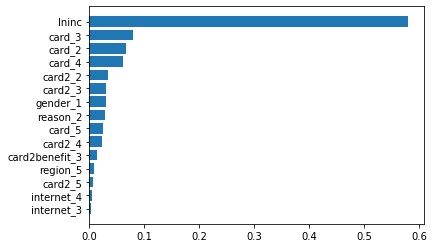

In [107]:
#Feature Impotance for Random Forest Model
rf_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : gscv_rf.best_estimator_.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

plt.barh(width = rf_fi.Importance, y = rf_fi.Features)

### Gradient Boost Model

In [108]:
#Getting parameters for best fit using GridSeachCV
pg = {  'max_depth' : range(1,6,1),
        'min_samples_split' : [2,3,4],
        'min_samples_leaf' : range(12,17,1)
     }

gscv_gb = GridSearchCV(estimator = GradientBoostingRegressor(random_state = 123), 
                     param_grid = pg,
                     cv = 5,
                     n_jobs = -1).fit(train_x, train_y)



In [109]:
#Best fit Parameters
gscv_gb.best_params_

{'max_depth': 3, 'min_samples_leaf': 16, 'min_samples_split': 2}

In [110]:
#Best Score
gscv_gb.best_score_

0.3178781226858934

In [111]:
#Using best fit parameters to fit the model
gb = gscv_gb.best_estimator_

#Predicting total spent on train and test dataset
train.loc[:,'gb_pred_spent'] = np.exp(gb.predict(train_x))
test.loc[:,'gb_pred_spent'] = np.exp(gb.predict(test_x))

#R-square Score
gb_r2 = metrics.r2_score(train.total_spent, train.gb_pred_spent)

print('R-square Score:', gb_r2)

#Getting Mean Absolute Percentage Error - MAPE
gb_MAPE_train = np.mean(np.abs(train['total_spent'] - train['gb_pred_spent'])/train['total_spent'])
gb_MAPE_test = np.mean(np.abs(test['total_spent'] - test['gb_pred_spent'])/test['total_spent'])
                    
print('Training MAPE: ',gb_MAPE_train,' | ','Testing MAPE:' ,gb_MAPE_test)

R-square Score: 0.3220784522139494
Training MAPE:  0.5109659791880249  |  Testing MAPE: 0.5007496910452197


C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [112]:
#Getting Mean Squared Error Metric - MSE
MSE_train = metrics.mean_squared_error(train.total_spent, train.gb_pred_spent)
MSE_test = metrics.mean_squared_error(test.total_spent, test.gb_pred_spent)

#Getting Root Mean Squared Error - RMSE
gb_RMSE_train = np.sqrt(MSE_train)
gb_RMSE_test = np.sqrt(MSE_test)

print('Training MSE: ',MSE_train,' | ','Testing MSE:' ,MSE_test)
print('Training RMSE: ',gb_RMSE_train,' | ','Testing RMSE:' ,gb_RMSE_test)

Training MSE:  86330.330623391  |  Testing MSE: 87971.33680270915
Training RMSE:  293.82023521771094  |  Testing RMSE: 296.5996237399993


In [113]:
#Getting Mean Absolute Error Metric - MAE
MAE_train = metrics.mean_absolute_error(train.total_spent, train.gb_pred_spent)
MAE_test = metrics.mean_absolute_error(test.total_spent, test.gb_pred_spent)

print('Training MAE: ',MAE_train,' | ','Testing MAE:' ,MAE_test)

Training MAE:  188.42010055260215  |  Testing MAE: 195.05883422887996


In [114]:
#Getting Root Mean Squared Percentage Error - RMSPE
gb_RMSPE_train = np.sqrt(np.mean(((train['total_spent'] - train['gb_pred_spent'])/train['total_spent'])**2))
gb_RMSPE_test = np.sqrt(np.mean(((test['total_spent'] - test['gb_pred_spent'])/test['total_spent'])**2))

print('Training RMSPE:', gb_RMSPE_train,' | ','Testing RMSPE:', gb_RMSPE_test)

Training RMSPE: 1.260710966446687  |  Testing RMSPE: 1.289032466041477


In [115]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train.total_spent, train.gb_pred_spent)
Corr_test = stats.stats.pearsonr(test.total_spent, test.gb_pred_spent)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.6075739634071355, 0.0) | Test Data:  (0.5241611685361638, 1.2632082308745999e-106)


In [116]:
#Decile Analysis
#Creating Deciles
train.loc[:,'gb_Deciles'] = pd.qcut(train.gb_pred_spent, 10, labels = False)
test.loc[:,'gb_Deciles'] = pd.qcut(test.gb_pred_spent, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
gb_decile_train = train.groupby(['gb_Deciles'])[['total_spent','gb_pred_spent']].mean().reset_index().sort_values(by = 'gb_Deciles', ascending = False)
gb_decile_test = test.groupby(['gb_Deciles'])[['total_spent','gb_pred_spent']].mean().reset_index().sort_values(by = 'gb_Deciles', ascending = False)

C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\prabhu\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

<BarContainer object of 15 artists>

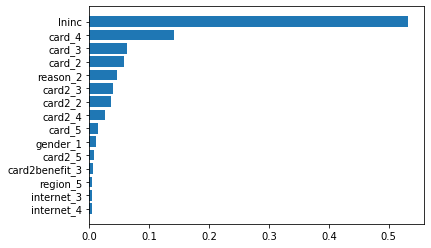

In [117]:
#Feature Impotance for Gradient Boost Model
gb_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : gscv_gb.best_estimator_.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

plt.barh(width = gb_fi.Importance, y = gb_fi.Features)

## Evaluating the different metrics for each model

In [119]:
#Getting accuracy and log loss for each model
model_data = pd.DataFrame({'Regressor' : ['LinearRegressor', 'KNeighborsRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor'],
                        'R2 Score' : [model2.rsquared, knn_r2, rf_r2, gb_r2],
                        'MAPE_train' : [MAPE_train, knn_MAPE_train, MAPE_train, gb_MAPE_train],
                        'MAPE_test' : [MAPE_test, knn_MAPE_test, MAPE_test, gb_MAPE_test],
                        'RMSE_train' : [RMSE_train, knn_RMSE_train, RMSE_train, gb_RMSE_train],
                        'RMSE_test' : [RMSE_test, knn_RMSE_test, RMSE_test, gb_RMSE_test],
                        'RMSPE_train' : [RMSPE_train, knn_RMSPE_train, RMSPE_train, gb_RMSPE_train],  
                        'RMSPE_test' : [RMSPE_test, knn_RMSPE_test, RMSPE_test, gb_RMSPE_test]
                        })

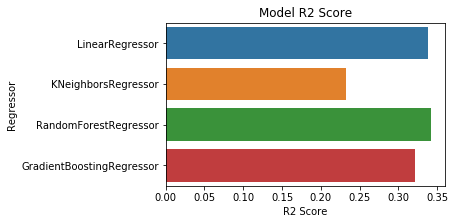

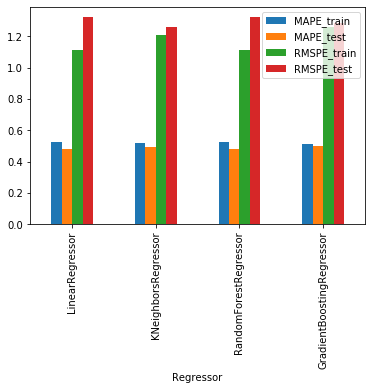

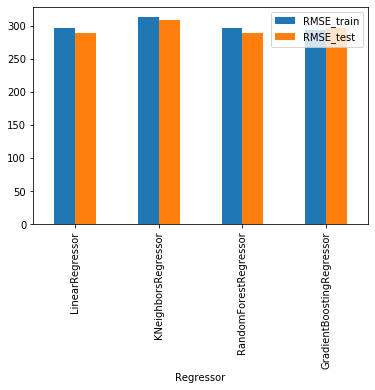

In [120]:
#Visualizing different metrics of the models
plt.figure(figsize = (5,3))
sns.barplot(data = model_data, x = model_data['R2 Score'], y = model_data.Regressor)
plt.title('Model R2 Score')

model_data.plot(x = 'Regressor', y = ['MAPE_train', 'MAPE_test', 'RMSPE_train', 'RMSPE_test'], kind = 'bar')
model_data.plot(x = 'Regressor', y = ['RMSE_train', 'RMSE_test'], kind = 'bar')
plt.show()

In [124]:
model_data

,Regressor,R2 Score,MAPE_train,MAPE_test,RMSE_train,RMSE_test,RMSPE_train,RMSPE_test
0,LinearRegressor,0.337919,0.528324,0.482551,297.049402,288.204904,1.110693,1.322870
1,KNeighborsRegressor,0.232169,0.519827,0.493940,312.697742,307.987962,1.209856,1.257639
2,RandomForestRegressor,0.342654,0.528324,0.482551,297.049402,288.204904,1.110693,1.322870
3,GradientBoostingRegressor,0.322078,0.510966,0.500750,293.820235,296.599624,1.260711,1.289032


- Random Forest Regressor is showing highest R2 value.

In [121]:
#Making Final Prediction using all models
pre_df = pd.DataFrame()
ds_new = data_new[X_cols]
pre_df['lr_pred_spent'] = np.exp(model2.predict(ds_new))
pre_df['knn_pred_spent'] = np.exp(knn.predict(ds_new))
pre_df['rf_pred_spent'] = np.exp(rf.predict(ds_new))
pre_df['gb_pred_spent'] = np.exp(gb.predict(ds_new))

final_ds = pd.concat([ds_new,data_new.total_spent,pre_df], axis = 1)

In [122]:
final_ds

,card2_2,card2_3,card2_4,card2_5,card2benefit_3,card_2,card_3,card_4,card_5,gender_1,internet_3,internet_4,lninc,reason_2,region_5,total_spent,lr_pred_spent,knn_pred_spent,rf_pred_spent,gb_pred_spent
0,0,0,0,1,0,0,1,0,0,1,0,0,3.433987,0,0,149.46,332.195400,332.456300,333.103026,346.175246
1,0,0,1,0,1,1,0,0,0,0,0,1,2.708050,0,1,77.54,247.972019,308.584075,314.870718,225.241804
2,0,0,1,0,1,1,0,0,0,1,0,0,3.555348,1,0,359.97,370.350570,347.293123,507.709066,425.996786
3,0,1,0,0,0,1,0,0,0,0,0,0,2.995732,0,0,359.41,273.165951,328.078700,338.214418,308.496436
4,0,0,0,0,0,0,0,1,0,0,1,0,3.135494,0,0,507.83,394.193986,457.085277,370.045135,382.640863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,1,0,0,0,0,0,0,0,0,0,0,5.278115,0,0,1425.67,1101.120116,904.480143,946.076856,1050.032546
4996,0,0,0,1,0,0,1,0,0,0,0,0,4.418841,0,0,366.35,494.434397,522.130264,583.170727,391.951782
4997,1,0,0,0,0,0,0,0,0,0,0,0,4.682131,0,0,1527.75,871.275411,679.339164,924.017325,813.141994
4998,0,0,1,0,0,0,1,0,0,0,1,0,5.241747,0,0,752.95,611.604623,530.592844,792.625694,634.647422
